**Individual Graded Exercise 1**

**Part 1: Regular expression warmup**

In [1]:
import re
import pandas as pd
!pip install clean-text
from cleantext import clean
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# Assume that cpr is passed as string
# Extend the regualar expression to not accept DD and MM of 00
# For now just do an if statement
def cpr_lexing(cpr):
    pattern = re.compile("(^[0-3][0-9])([0-1][0-9])([0-9]{2})-?([0-9]{4})")
    match = pattern.match(cpr)
    if (match and match.group(1) != "00" and match.group(2) != "00"
        and match.group(4) != "0000"):
        print("String is a cpr")
        DD = match.group(1)
        MM = match.group(2)
        YY = match.group(3)
        IIII = match.group(4)
        return int(DD), int(MM), int(YY), int(IIII)
    else:
        print("String is not a cpr")
    pass

# Function that takes a cpr and returns the century
def get_Century(cpr):
    _, _, YY, IIII = cpr_lexing(cpr)
    if (1 <= IIII <= 3999):
        return 1900
    elif (4000 <= IIII <= 4999):
        if (0 <= YY <= 36):
            return 2000
        elif (37 <= YY <= 99):
            return 1900
    elif (5000 <= IIII <= 8999):
        if (0 <= YY <= 57):
            return 2000
        elif (58 <= YY <= 99):
            return 1800
    elif (9000 <= IIII <= 9999):
        if (0 <= YY <= 36):
            return 2000
        elif (37 <= YY <= 99):
            return 1900

cpr1 = "010199-5000"
print(get_Century(cpr1))

String is a cpr
1800


**Part 2: Processing the FakeNewsCorpus data set**

In [3]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv", index_col = 0)

In [4]:
raw_data['content'][1]

'AWAKENING OF 12 STRANDS of DNA – “Reconnecting with You” Movie\n\n% of readers think this story is Fact. Add your two cents.\n\nHeadline: Bitcoin & Blockchain Searches Exceed Trump! Blockchain Stocks Are Next!\n\n[January 24, 2018 - ZurichTimes.net]\n\nAs Miles Johnston was giving update, it was another case of Strange Synchronicities of Goodness Hidden inside of Tests and Trials, like a Follow the WhiteRabbit down the Rabbit Hole type of exercise.\n\nIn Researching the 12 Strands of DNA we came across some articles, one in particular was as a Strange Synchronicity written exactly 1 year ago on the Same Topic.\n\nhttps://www.youtube.com/watch?v=_6Ze1mrs4BQ\n\nhttps://www.youtube.com/watch?v=2nKcDiIc8JY\n\nWhat are the 12 Strands of our DNA and Why is a War Against our DNA?\n\nTrailer for Awakening of 12 Strands\n\nThe Full Video is only available as a Paid Video on Vimeo.\n\nAWAKENING OF 12 STRANDS – “Reconnecting with You”\n\nvimeo.com/ondemand/Awakeningof12strands\n\nAWAKENING OF 12

In [5]:
def clean_text(text):
    text = text.lower()
    text = remove_multiple_whitespace(text)
    text = replace_numbers(text)
    text = replace_emails(text)
    text = replace_urls(text)
    text = replace_dates(text)
    return text

def remove_multiple_whitespace(text):
    text = re.sub("\r\r+" , "\r", text)
    text = re.sub("\n\n+" , "\n", text)
    text = re.sub("\t\t+" , "\t", text)
    text = re.sub("\f\f+" , "\f", text)
    text = re.sub("  +" , " ", text)
    return text

def replace_numbers(text):
    pattern = re.compile("\d+[^\s\w]?\d*")
    text = re.sub(pattern, "<NUM>", text)
    return text

def replace_emails(text):
    pattern = re.compile(r"[a-zA-Z0-9_.<>+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+")
    text = re.sub(pattern, "<EMAIL>", text)
    return text

def replace_urls(text):
    pattern = re.compile(r"(?:https?:(?:/{1,3})|[a-z0-9.\-]+[.][a-z]{1,3})(:?[^\s()<>{}\[\]]+)")
    text = re.sub(pattern, "<URL>", text)
    return text

# Consider improving with laziness vs greediness in places where only month and number are listed etc.
def replace_dates(text):
    pattern = re.compile(r"(?:january|february|march|april|may|june|july|august|september|october|november|december|jan|feb|mar|apr|may)?(:?[. ]?<NUM>(?:th)?[, ]{0,2}<NUM>)")
    text = re.sub(pattern, "<DATE>", text)
    return text

In [6]:
clean_data_homemade = raw_data.copy()
clean_data_homemade['content'] = raw_data['content'].apply(clean_text)

In [7]:
clean_data_library = raw_data.copy()
# Can't clean date with clean-text library
clean_anon = (lambda x: clean(x,
        fix_unicode=False,               # fix various unicode errors
        to_ascii=False,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                  # replace all URLs with a special token
        no_emails=True,                # replace all email addresses with a special token
        no_phone_numbers=False,         # replace all phone numbers with a special token
        no_numbers=True,               # replace all numbers with a special token
        no_digits=True,                # replace all digits with a special token
        no_currency_symbols=False,      # replace all currency symbols with a special token
        no_punct=False,                 # remove punctuations
        replace_with_punct="",          # instead of removing punctuations you may replace them
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="<NUM>",
        replace_with_digit="0",
        replace_with_currency_symbol="<CUR>",
        lang="en"                       # set to 'de' for German special handling
    )
)

In [8]:
clean_data_library['content'] = raw_data['content'].apply(clean_anon)

**Part 3: Descriptive frequency analysis of the data**

I assume that the preprocessing done in step 2 is intended and won't do further e.g. stemming, stopword removal etc.

In [9]:
results_raw = raw_data.loc[:,('content')].str.split().sum()
unique_word_count_raw = len(set(results_raw))
results = clean_data_library.loc[:,('content')].str.split().sum()
unique_word_count = len(set(results))
print('Unique words initially: {}'.format(unique_word_count_raw))
print('Unique words after simple cleaning: {}'.format(unique_word_count))

Unique words initially: 30005
Unique words after simple cleaning: 25640


In [10]:
results_counts = Counter(results)
sorted_results_top50 = results_counts.most_common(50)
words, frequencies = zip(*sorted_results_top50)

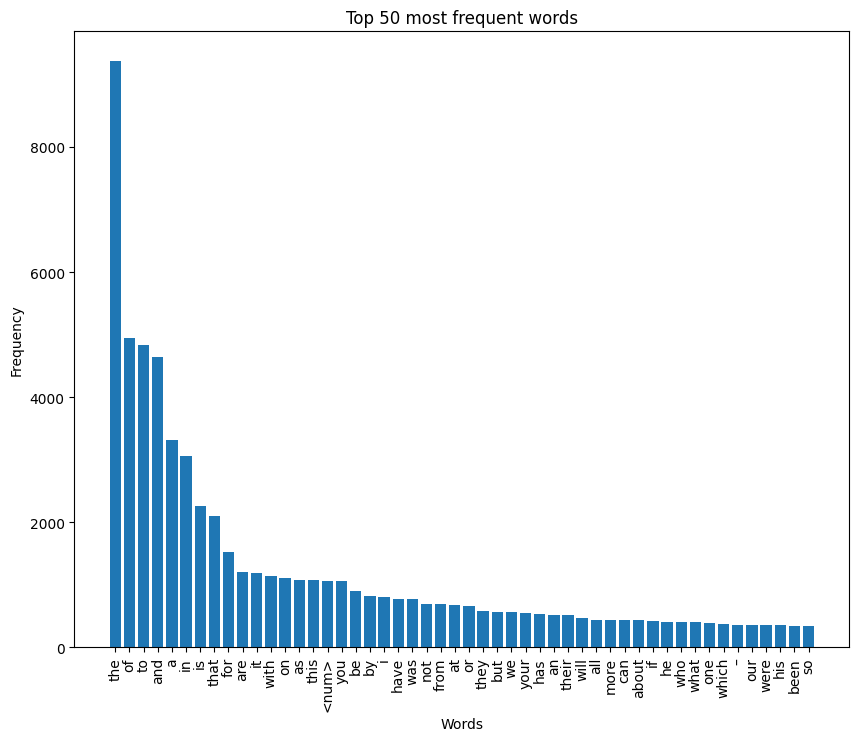

In [11]:
# plot
plt.figure(figsize=(10,8))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 most frequent words')
plt.xticks(rotation=90)
plt.show()